AKTIEN-ANALYSE: ORCL
Zeitraum: 2020-01-01 bis 2025-01-01

✓ Daten erfolgreich geladen für ORCL
  Anzahl Beobachtungen: 1258
  Zeitraum: 2020-01-02 bis 2024-12-31

DESKRIPTIVE STATISTIK
count    1258.000000
mean       91.429555
std        32.392387
min        39.799999
25%        66.557499
50%        85.405003
75%       112.202499
max       192.429993
Name: Kurs, dtype: float64

RENDITE-KENNZAHLEN
Durchschnittliche tägliche Rendite:     0.1108%
Tägliche Volatilität:                    2.0662%
Annualisierte Rendite:                    32.20%
Annualisierte Volatilität:                32.80%
Sharpe Ratio (risikofreier Zins 4%):       0.86
Schiefe (Skewness):                         1.05
Kurtosis:                                  17.26

DRAWDOWN-ANALYSE
Max. Drawdown:       -41.08%
Datum:               2022-09-30
Erholungszeit:       237 Tage

VISUALISIERUNGEN


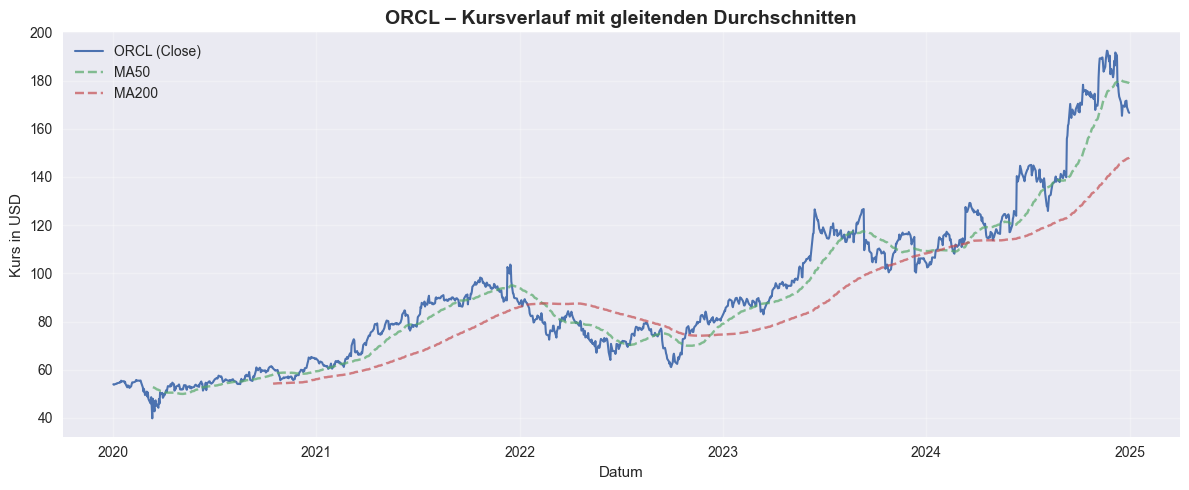

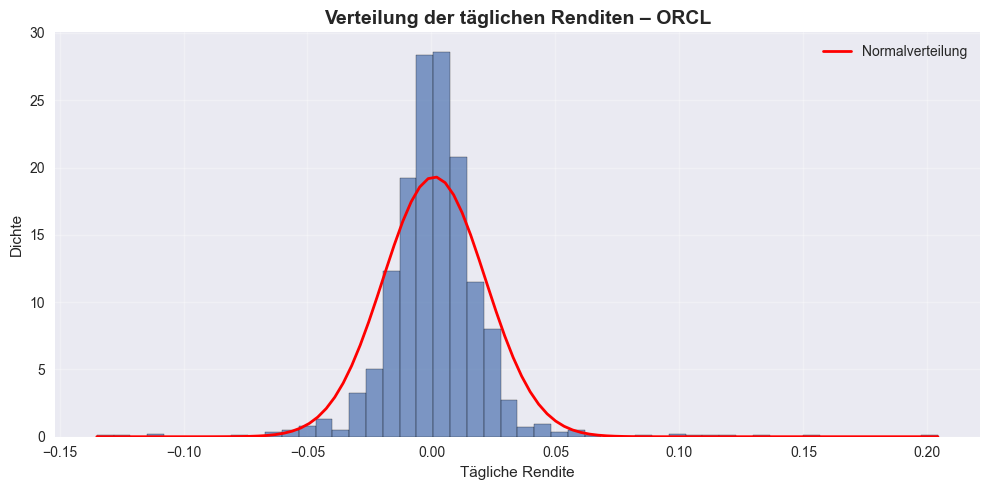

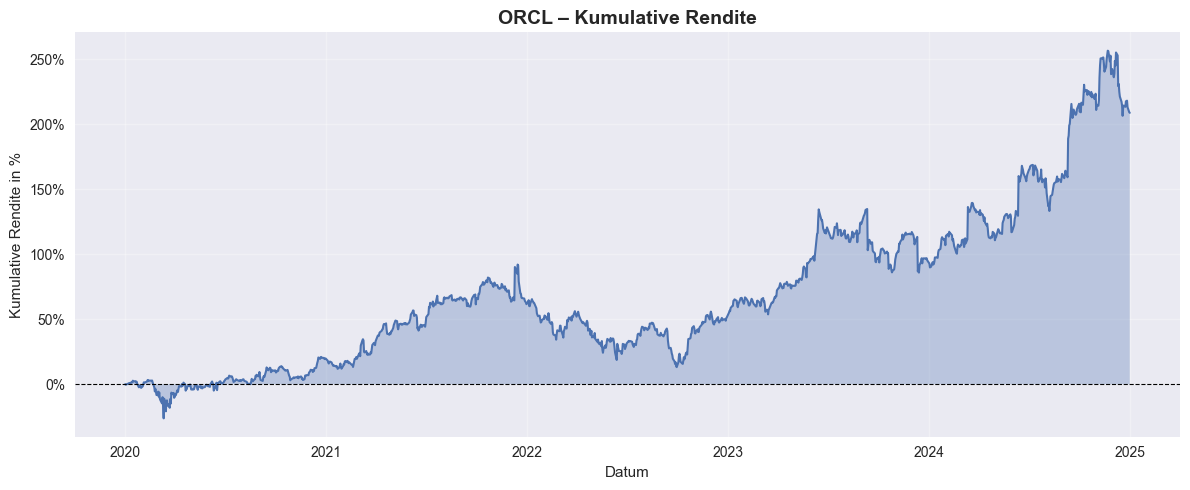

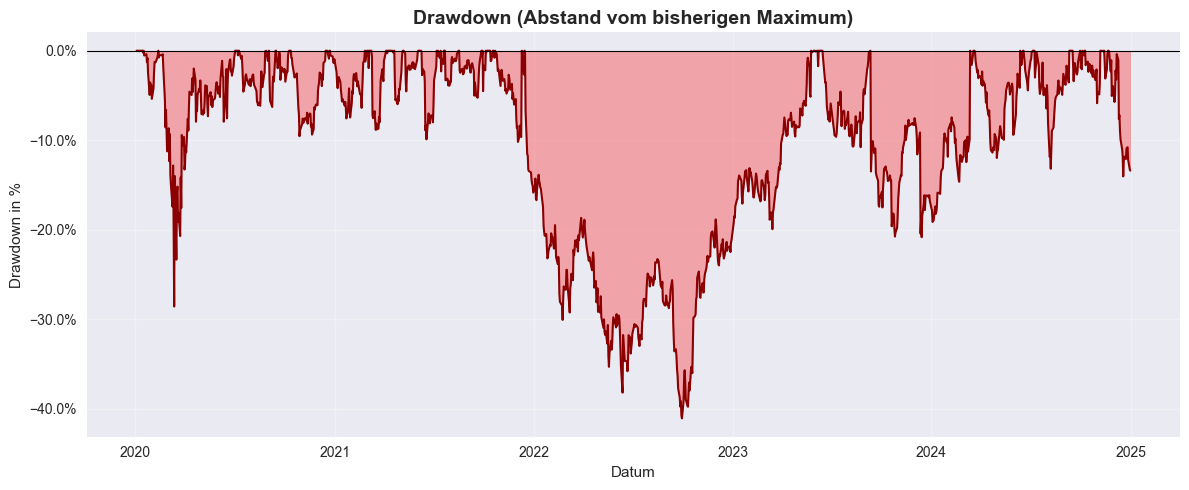

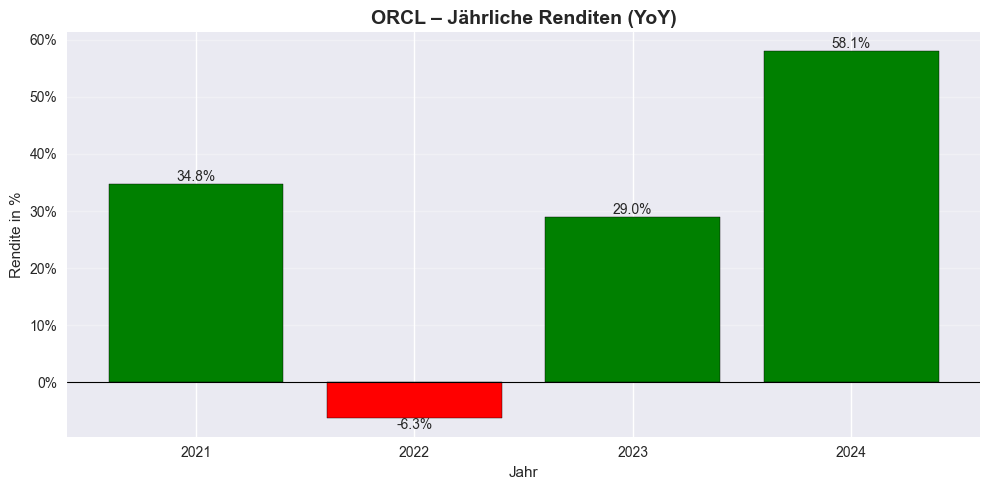

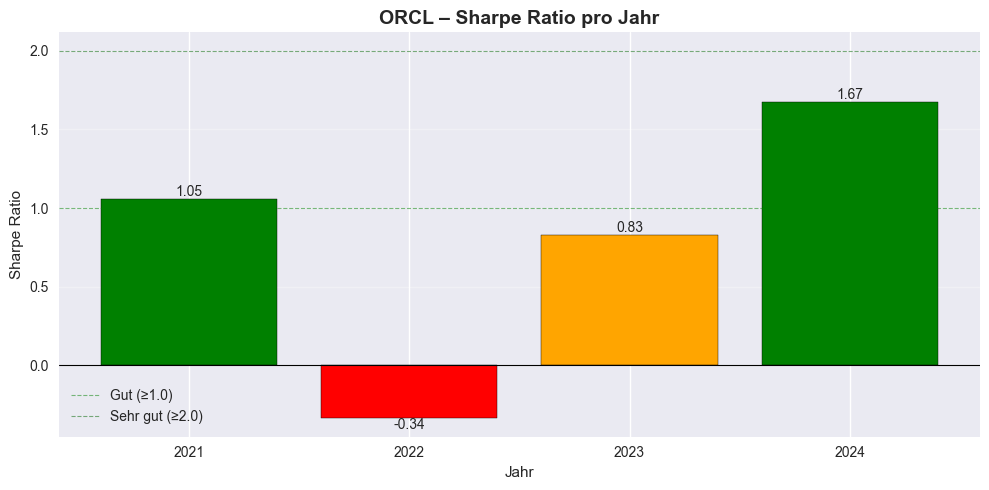

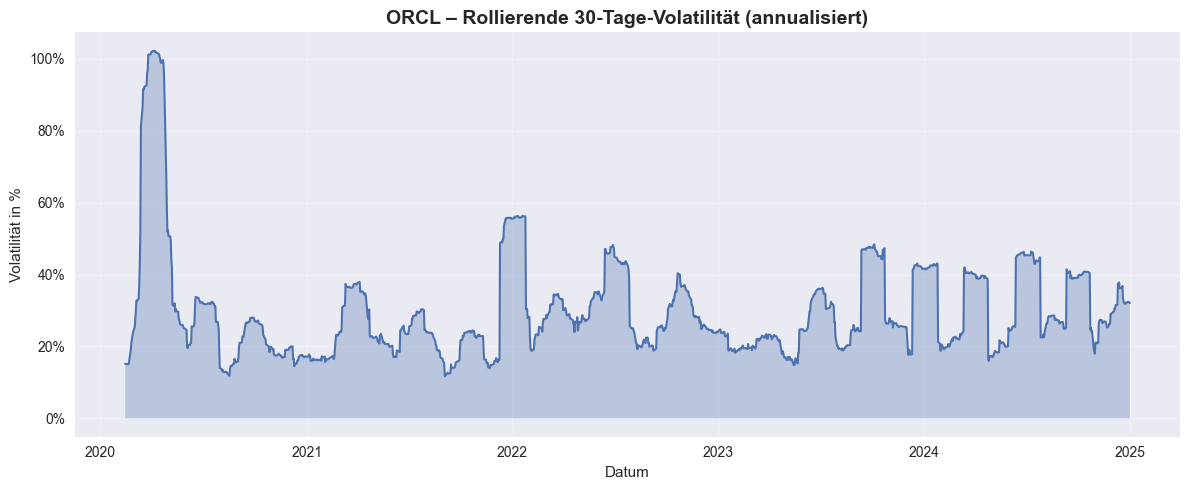

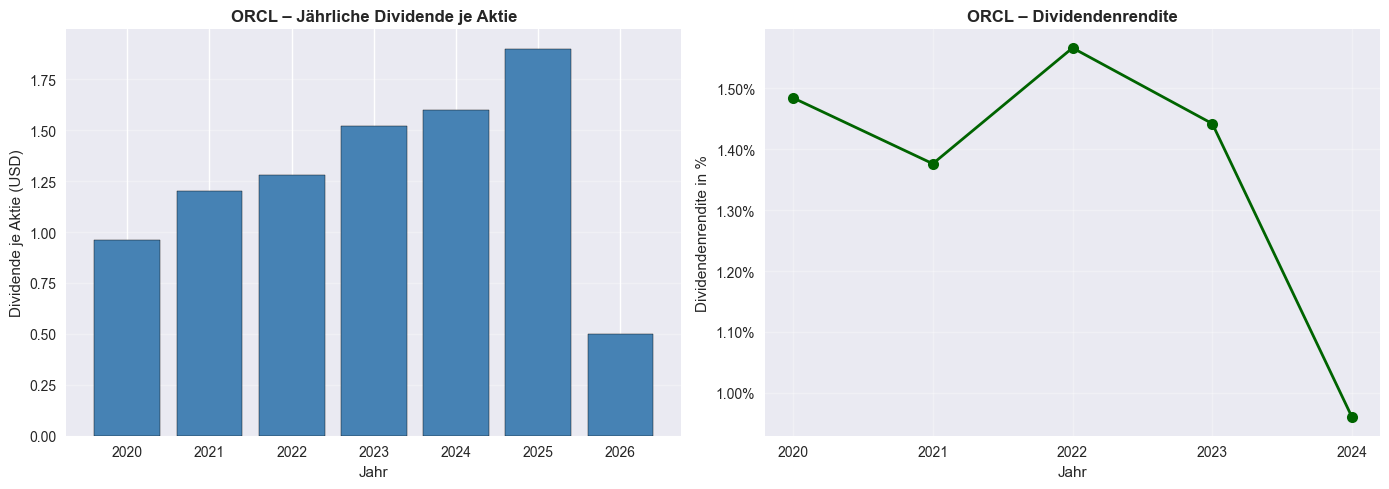


JAHRESÜBERSICHT
      Rendite (%)  Volatilität (%)  Dividende ($)  Div-Rendite (%)
Date                                                              
2020          NaN            40.59           0.96             1.48
2021        34.81            29.22           1.20             1.38
2022        -6.27            30.54           1.28             1.57
2023        28.98            30.21           1.52             1.44
2024        58.06            32.28           1.60             0.96
2025          NaN              NaN           1.90              NaN

ANALYSE ABGESCHLOSSEN


In [9]:
"""
Aktien-Reporting für Yahoo Finance Daten
Jede Zeile ist kommentiert und erklärt, was sie macht.
"""

# -----------------------------
# Imports - Laden der benötigten Bibliotheken
# -----------------------------
import numpy as np  # Mathematische Funktionen und Arrays
import pandas as pd  # Datenanalyse und DataFrames
import yfinance as yf  # Yahoo Finance API zum Laden von Aktiendaten
import matplotlib.pyplot as plt  # Plotting-Bibliothek für Diagramme
import matplotlib.ticker as mtick  # Formatierung von Achsen (z.B. Prozent)
from datetime import datetime  # Datum- und Zeitfunktionen
import warnings  # Verwaltung von Warnmeldungen

# Unterdrücke Warnungen (macht Output sauberer)
warnings.filterwarnings('ignore')

# Setze den Stil für alle Plots auf seaborn (moderner Look)
plt.style.use('seaborn-v0_8')

# -----------------------------
# Konfiguration (zentral verwaltbar)
# -----------------------------
class Config:
    """
    Zentrale Konfigurationsklasse für alle Einstellungen.
    Alle Parameter an einem Ort = leichter zu ändern.
    """
    # Ticker-Symbol der zu analysierenden Aktie
    TICKER = "ORCL"

    # Startdatum für die Datenabfrage (Format: YYYY-MM-DD)
    START = "2020-01-01"

    # Enddatum für die Datenabfrage (Format: YYYY-MM-DD)
    END = "2025-01-01"

    # Risikofreier Zinssatz für Sharpe Ratio Berechnung (4% = 0.04)
    RISK_FREE_RATE = 0.04

    # Standardgröße für breite Plots (Breite, Höhe in Zoll)
    FIGSIZE_WIDE = (12, 5)

    # Standardgröße für mittlere Plots
    FIGSIZE_MEDIUM = (10, 5)

    # Standardgröße für kleine Plots
    FIGSIZE_SMALL = (10, 4)


# -----------------------------
# Hilfsfunktionen
# -----------------------------
def load_stock_data(ticker, start, end):
    """
    Lädt Aktiendaten von Yahoo Finance mit Fehlerbehandlung.

    Args:
        ticker: Ticker-Symbol der Aktie (z.B. "ORCL")
        start: Startdatum als String (z.B. "2020-01-01")
        end: Enddatum als String (z.B. "2025-01-01")

    Returns:
        DataFrame mit Kursdaten oder None bei Fehler
    """
    # Try-Block: Versuche den folgenden Code auszuführen
    try:
        # Lade Daten von Yahoo Finance
        raw = yf.download(
            ticker,  # Welche Aktie
            start=start,  # Ab wann
            end=end,  # Bis wann
            auto_adjust=False,  # Keine automatische Anpassung für Splits/Dividenden
            progress=False  # Kein Fortschrittsbalken in der Konsole
        )

        # Prüfe, ob der DataFrame leer ist (keine Daten gefunden)
        if raw.empty:
            # Gib Fehlermeldung aus
            print(f"⚠️  Keine Daten für {ticker} gefunden!")
            # Gib None zurück (bedeutet "kein Wert")
            return None

        # Prüfe, ob die Spalten ein MultiIndex sind (manchmal macht Yahoo das)
        if isinstance(raw.columns, pd.MultiIndex):
            # Nimm nur die erste Ebene des MultiIndex
            raw.columns = raw.columns.get_level_values(0)

        # Extrahiere nur die Close-Spalte (Schlusskurse)
        # dropna() entfernt Zeilen mit fehlenden Werten
        # rename() benennt die Spalte von 'Close' zu 'Kurs' um
        # copy() erstellt eine echte Kopie (nicht nur Referenz)
        data = raw[['Close']].dropna().rename(columns={'Close': 'Kurs'}).copy()

        # Erfolgreiche Meldung mit Checkmark
        print(f"✓ Daten erfolgreich geladen für {ticker}")

        # Zeige Anzahl der geladenen Datenpunkte
        print(f"  Anzahl Beobachtungen: {len(data)}")

        # Zeige Zeitraum: .min() findet frühestes Datum, .max() spätestes
        # .date() konvertiert Timestamp zu reinem Datum
        print(f"  Zeitraum: {data.index.min().date()} bis {data.index.max().date()}")

        # Gib die Daten zurück
        return data

    # Except-Block: Falls ein Fehler auftritt, fange ihn ab
    except Exception as e:
        # Gib Fehlermeldung mit Details aus
        print(f"❌ Fehler beim Laden der Daten: {e}")
        # Gib None zurück
        return None


def calculate_returns_metrics(returns):
    """
    Berechnet verschiedene Rendite-Kennzahlen.

    Args:
        returns: pandas Series mit täglichen Renditen (z.B. 0.01 = 1%)

    Returns:
        Dictionary mit allen berechneten Kennzahlen
    """
    # Berechne durchschnittliche tägliche Rendite
    # .mean() summiert alle Werte und teilt durch Anzahl
    mean_daily = returns.mean()

    # Berechne tägliche Volatilität (Standardabweichung)
    # .std() misst die Streuung der Renditen um den Mittelwert
    vol_daily = returns.std()

    # Annualisiere die Rendite (auf Jahresbasis hochrechnen)
    # Formel: (1 + tägliche Rendite)^252 - 1
    # 252 = durchschnittliche Handelstage pro Jahr
    annual_return = (1 + mean_daily) ** 252 - 1

    # Annualisiere die Volatilität
    # Formel: tägliche Volatilität * Wurzel(252)
    # np.sqrt() berechnet die Quadratwurzel
    annual_vol = vol_daily * np.sqrt(252)

    # Berechne Sharpe Ratio (risikoadjustierte Rendite)
    # Formel: (Rendite - Risikofreier Zins) / Volatilität
    # if-else verhindert Division durch 0
    sharpe_ratio = (annual_return - Config.RISK_FREE_RATE) / annual_vol if annual_vol != 0 else 0

    # Berechne Schiefe (Skewness)
    # .skew() misst die Asymmetrie der Verteilung
    # Negativ = mehr extreme Verluste, Positiv = mehr extreme Gewinne
    skewness = returns.skew()

    # Berechne Kurtosis (Wölbung)
    # .kurtosis() misst die "Schwere" der Verteilungsenden
    # Hoch = mehr Extremwerte als Normalverteilung
    kurtosis = returns.kurtosis()

    # Gib alle Kennzahlen als Dictionary zurück
    # Dictionary = Schlüssel-Wert-Paare (wie eine Tabelle)
    return {
        'mean_daily': mean_daily,
        'vol_daily': vol_daily,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'skewness': skewness,
        'kurtosis': kurtosis
    }


def calculate_drawdown(returns):
    """
    Berechnet Drawdown-Metriken (Rückgang vom Höchststand).

    Args:
        returns: pandas Series mit täglichen Renditen

    Returns:
        Tuple mit (drawdown_series, max_drawdown, datum, recovery_days)
    """
    # Berechne kumulative Rendite (Gesamtentwicklung seit Start)
    # (1 + returns) multipliziert jeden Tag: (1+r1)*(1+r2)*...
    # .cumprod() = cumulative product (kumulative Multiplikation)
    cum = (1 + returns).cumprod()

    # Berechne laufendes Maximum (höchster Wert bis zu jedem Zeitpunkt)
    # .cummax() speichert für jeden Tag den bisherigen Höchstwert
    running_max = cum.cummax()

    # Berechne Drawdown (Abstand vom Maximum in Prozent)
    # Formel: aktueller Wert / Maximum - 1
    # Beispiel: Kurs bei 80, Maximum war 100 → 80/100-1 = -0.2 = -20%
    drawdown = cum / running_max - 1

    # Finde maximalen Drawdown (größter Verlust vom Höchststand)
    # .min() findet den kleinsten (negativsten) Wert
    max_dd = drawdown.min()

    # Finde das Datum des maximalen Drawdowns
    # .idxmin() gibt den Index (hier: Datum) des minimalen Werts zurück
    max_dd_date = drawdown.idxmin()

    # Berechne Recovery-Zeit (wie lange bis zur Erholung?)
    # Nur wenn es überhaupt einen Drawdown gab (< 0)
    if max_dd < 0:
        # Finde den Start des Drawdowns (letztes Maximum vor dem Tief)
        # [:max_dd_date] = alle Daten bis zum Tiefpunkt
        # == vergleicht ob Werte gleich sind
        # .iloc[::-1] kehrt die Reihenfolge um (rückwärts)
        # .idxmax() findet ersten True-Wert = letztes Maximum
        dd_start = (cum[:max_dd_date] == running_max[:max_dd_date]).iloc[::-1].idxmax()

        # Finde alle Zeitpunkte nach dem Tief, wo der Wert wieder >= Maximum ist
        recovery = cum[max_dd_date:][cum[max_dd_date:] >= running_max[max_dd_date]]

        # Berechne Anzahl Tage zwischen Tief und Erholung
        # .days extrahiert die Anzahl Tage aus einem timedelta
        # if len(recovery) > 0 prüft, ob Erholung überhaupt stattfand
        recovery_days = (recovery.index[0] - max_dd_date).days if len(recovery) > 0 else None
    else:
        # Kein Drawdown vorhanden
        recovery_days = None

    # Gib alle Werte als Tuple zurück
    return drawdown, max_dd, max_dd_date, recovery_days


def plot_price_chart(data, ticker):
    """
    Erstellt einen Kursverlauf-Chart mit gleitenden Durchschnitten.

    Args:
        data: DataFrame mit Kursdaten
        ticker: Ticker-Symbol für den Titel
    """
    # Erstelle neue Figure (Zeichenfläche) mit definierter Größe
    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Plotte den Kursverlauf
    # data.index = X-Achse (Datum)
    # data['Kurs'] = Y-Achse (Kurswerte)
    # label = Text für die Legende
    # linewidth = Dicke der Linie in Punkten
    plt.plot(data.index, data['Kurs'], label=f'{ticker} (Close)', linewidth=1.5)

    # Berechne 50-Tage gleitenden Durchschnitt
    # .rolling(50) erstellt ein Fenster von 50 Tagen
    # .mean() berechnet Durchschnitt in diesem Fenster
    data['MA50'] = data['Kurs'].rolling(50).mean()

    # Berechne 200-Tage gleitenden Durchschnitt (langfristiger Trend)
    data['MA200'] = data['Kurs'].rolling(200).mean()

    # Plotte MA50 (kurzfristiger Trend)
    # alpha = Transparenz (0=unsichtbar, 1=voll sichtbar)
    # linestyle='--' = gestrichelte Linie
    plt.plot(data.index, data['MA50'], label='MA50', alpha=0.7, linestyle='--')

    # Plotte MA200 (langfristiger Trend)
    plt.plot(data.index, data['MA200'], label='MA200', alpha=0.7, linestyle='--')

    # Setze Titel des Plots
    # fontsize = Schriftgröße
    # fontweight = Schriftstärke (bold = fett)
    plt.title(f'{ticker} – Kursverlauf mit gleitenden Durchschnitten',
              fontsize=14, fontweight='bold')

    # Beschrifte X-Achse
    plt.xlabel('Datum')

    # Beschrifte Y-Achse
    plt.ylabel('Kurs in USD')

    # Zeige Legende (erklärt die Linien)
    plt.legend()

    # Füge Gitternetz hinzu
    # True = aktiviert, alpha = Transparenz
    plt.grid(True, alpha=0.3)

    # Optimiere Layout (verhindert überlappende Labels)
    plt.tight_layout()

    # Zeige den Plot an
    plt.show()


def plot_returns_distribution(returns, ticker):
    """
    Erstellt ein Histogramm der Renditen mit Normalverteilungskurve.

    Args:
        returns: pandas Series mit täglichen Renditen
        ticker: Ticker-Symbol für den Titel
    """
    # Erstelle neue Figure mit mittlerer Größe
    plt.figure(figsize=Config.FIGSIZE_MEDIUM)

    # Erstelle Histogramm
    # bins=50 = Anzahl der Balken (Klassenbreite)
    # density=True = normalisiert auf Fläche=1 (für Vergleich mit Normalverteilung)
    # alpha=0.7 = leicht transparent
    # edgecolor='black' = schwarze Umrandung der Balken
    n, bins, patches = plt.hist(returns, bins=50, density=True,
                                 alpha=0.7, edgecolor='black')

    # Berechne Parameter der Normalverteilung
    mu, sigma = returns.mean(), returns.std()  # Mittelwert und Standardabweichung

    # Erstelle X-Werte für die Normalverteilungskurve
    # np.linspace erstellt gleichmäßig verteilte Werte zwischen min und max
    x = np.linspace(returns.min(), returns.max(), 100)

    # Plotte Normalverteilungskurve
    # Formel der Gauß'schen Glockenkurve:
    # f(x) = 1/(σ√(2π)) * e^(-0.5*((x-μ)/σ)²)
    # np.exp() = e^x (Exponentialfunktion)
    # np.sqrt() = Quadratwurzel
    # np.pi = π (3.14159...)
    plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5*((x - mu)/sigma)**2),
             'r-',  # 'r-' = rote durchgezogene Linie
             linewidth=2,  # Dicke Linie
             label='Normalverteilung')  # Label für Legende

    # Setze Titel
    plt.title(f'Verteilung der täglichen Renditen – {ticker}',
              fontsize=14, fontweight='bold')

    # Beschrifte Achsen
    plt.xlabel('Tägliche Rendite')
    plt.ylabel('Dichte')

    # Zeige Legende
    plt.legend()

    # Gitternetz
    plt.grid(True, alpha=0.3)

    # Layout optimieren
    plt.tight_layout()

    # Plot anzeigen
    plt.show()


def plot_cumulative_returns(data, ticker):
    """
    Erstellt Chart für kumulative Renditen (Gesamtentwicklung).

    Args:
        data: DataFrame mit 'Kumulierte_Rendite' Spalte
        ticker: Ticker-Symbol für den Titel
    """
    # Neue Figure erstellen
    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Plotte kumulative Rendite in Prozent
    # * 100 konvertiert von Dezimal (0.5) zu Prozent (50)
    plt.plot(data.index, data['Kumulierte_Rendite'] * 100, linewidth=1.5)

    # Fülle Fläche unter der Kurve
    # fill_between() füllt den Bereich zwischen zwei y-Werten
    # 0 = untere Grenze (X-Achse)
    # data['Kumulierte_Rendite'] * 100 = obere Grenze (Kurve)
    # alpha=0.3 = leicht transparent
    plt.fill_between(data.index, 0, data['Kumulierte_Rendite'] * 100, alpha=0.3)

    # Titel setzen
    plt.title(f'{ticker} – Kumulative Rendite', fontsize=14, fontweight='bold')

    # Achsen beschriften
    plt.xlabel('Datum')
    plt.ylabel('Kumulative Rendite in %')

    # Füge horizontale Linie bei y=0 hinzu (Nulllinie)
    # axhline = axis horizontal line
    # y=0 = Position der Linie
    # color='black' = schwarze Linie
    # linestyle='--' = gestrichelt
    # linewidth=0.8 = dünn
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

    # Formatiere Y-Achse als Prozent
    # gca() = get current axis (hole aktuelle Achse)
    # yaxis = Y-Achse
    # set_major_formatter = setze Formatierung
    # PercentFormatter() = formatiert als Prozent (fügt % hinzu)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    # Gitternetz
    plt.grid(True, alpha=0.3)

    # Layout optimieren
    plt.tight_layout()

    # Plot anzeigen
    plt.show()


def plot_drawdown(drawdown, max_dd, max_dd_date):
    """
    Erstellt Drawdown-Chart (zeigt Verluste vom Höchststand).

    Args:
        drawdown: pandas Series mit Drawdown-Werten
        max_dd: maximaler Drawdown (float)
        max_dd_date: Datum des maximalen Drawdowns
    """
    # Neue Figure
    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Fülle Drawdown-Bereich (immer negativ oder 0)
    # fill_between füllt zwischen 0 und den Drawdown-Werten
    # color='red' = rote Füllung (signalisiert Verlust)
    # alpha=0.3 = transparent
    plt.fill_between(drawdown.index, 0, drawdown * 100, color='red', alpha=0.3)

    # Plotte Drawdown-Linie
    # color='darkred' = dunkelrote Linie
    plt.plot(drawdown.index, drawdown * 100, color='darkred', linewidth=1.5)

    # Füge Nulllinie hinzu (obere Grenze = kein Verlust)
    # linestyle='-' = durchgezogene Linie
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Titel
    plt.title('Drawdown (Abstand vom bisherigen Maximum)',
              fontsize=14, fontweight='bold')

    # Achsenbeschriftung
    plt.xlabel('Datum')
    plt.ylabel('Drawdown in %')

    # Y-Achse als Prozent formatieren
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    # Gitternetz
    plt.grid(True, alpha=0.3)

    # Layout
    plt.tight_layout()

    # Anzeigen
    plt.show()


def plot_annual_returns(annual_returns, ticker):
    """
    Erstellt Balkendiagramm für Jahresrenditen.

    Args:
        annual_returns: pandas Series mit Renditen pro Jahr
        ticker: Ticker-Symbol
    """
    # Neue Figure
    plt.figure(figsize=Config.FIGSIZE_MEDIUM)

    # Erstelle Liste mit Farben basierend auf Rendite
    # List comprehension: [ausdruck for item in liste if bedingung]
    # Grün wenn Wert >= 0, sonst Rot
    colors = ['green' if v >= 0 else 'red' for v in annual_returns.values]

    # Erstelle Balkendiagramm
    # annual_returns.index.astype(str) = konvertiere Jahre zu Strings für X-Achse
    # annual_returns.values * 100 = Renditen in Prozent
    # color=colors = verwende unsere Farbenliste
    # edgecolor='black' = schwarze Umrandung der Balken
    bars = plt.bar(annual_returns.index.astype(str),
                   annual_returns.values * 100,
                   color=colors,
                   edgecolor='black')

    # Füge Werte auf den Balken hinzu (Datenlabels)
    # for-Schleife über alle Balken
    for bar in bars:
        # Hole Höhe des Balkens (= Rendite)
        height = bar.get_height()

        # Füge Text hinzu
        # bar.get_x() = X-Position des Balkens
        # bar.get_width()/2 = halbe Breite (für Zentrierung)
        # height = Y-Position (oben auf dem Balken)
        # f'{height:.1f}%' = formatiere Zahl mit 1 Dezimalstelle und %
        # ha='center' = horizontal alignment = zentriert
        # va='bottom' wenn positiv, 'top' wenn negativ (verhindert Überlappung)
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center',
                va='bottom' if height >= 0 else 'top')

    # Titel
    plt.title(f'{ticker} – Jährliche Renditen (YoY)',
              fontsize=14, fontweight='bold')

    # Achsenbeschriftung
    plt.xlabel('Jahr')
    plt.ylabel('Rendite in %')

    # Nulllinie
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Y-Achse als Prozent
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    # Gitternetz nur auf Y-Achse
    # axis='y' = nur vertikal
    plt.grid(True, axis='y', alpha=0.3)

    # Layout
    plt.tight_layout()

    # Anzeigen
    plt.show()


def plot_rolling_volatility(vol_30d_ann, ticker):
    """
    Erstellt Chart für rollierende 30-Tage-Volatilität.

    Args:
        vol_30d_ann: pandas Series mit annualisierter Volatilität
        ticker: Ticker-Symbol
    """
    # Neue Figure
    plt.figure(figsize=Config.FIGSIZE_WIDE)

    # Plotte Volatilität in Prozent
    plt.plot(vol_30d_ann.index, vol_30d_ann.values * 100, linewidth=1.5)

    # Fülle Fläche unter der Kurve
    plt.fill_between(vol_30d_ann.index, 0, vol_30d_ann.values * 100, alpha=0.3)

    # Titel
    plt.title(f'{ticker} – Rollierende 30-Tage-Volatilität (annualisiert)',
              fontsize=14, fontweight='bold')

    # Achsenbeschriftung
    plt.xlabel('Datum')
    plt.ylabel('Volatilität in %')

    # Y-Achse als Prozent
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    # Gitternetz
    plt.grid(True, alpha=0.3)

    # Layout
    plt.tight_layout()

    # Anzeigen
    plt.show()


def plot_annual_sharpe_ratio(annual_returns, returns, ticker):
    """
    Erstellt Balkendiagramm für Sharpe Ratio pro Jahr.

    Args:
        annual_returns: pandas Series mit Jahresrenditen
        returns: pandas Series mit täglichen Renditen
        ticker: Ticker-Symbol
    """
    # Erstelle leeres Dictionary für Sharpe Ratios pro Jahr
    annual_sharpe = {}

    # Iteriere über alle Jahre in annual_returns
    # .items() gibt Paare von (Jahr, Rendite) zurück
    for year, annual_return in annual_returns.items():
        # Filtere die täglichen Renditen für dieses Jahr
        # returns.index.year == year wählt nur Daten aus diesem Jahr
        year_returns = returns[returns.index.year == year]

        # Berechne Volatilität für dieses Jahr
        # .std() = Standardabweichung der täglichen Renditen
        # * np.sqrt(252) = annualisieren (auf Jahresbasis hochrechnen)
        year_vol = year_returns.std() * np.sqrt(252)

        # Berechne Sharpe Ratio für dieses Jahr
        # Formel: (Jahresrendite - Risikofreier Zins) / Jahresvolatilität
        # if year_vol != 0 verhindert Division durch 0
        if year_vol != 0:
            # Speichere Sharpe Ratio im Dictionary unter dem Jahr
            annual_sharpe[year] = (annual_return - Config.RISK_FREE_RATE) / year_vol
        else:
            # Falls Volatilität 0 ist (sollte nicht vorkommen), setze auf 0
            annual_sharpe[year] = 0

    # Konvertiere Dictionary zu pandas Series
    # Series ist wie eine Liste mit Index (hier: Jahre)
    sharpe_series = pd.Series(annual_sharpe)

    # Erstelle neue Figure mit mittlerer Größe
    plt.figure(figsize=Config.FIGSIZE_MEDIUM)

    # Erstelle Farbliste basierend auf Sharpe Ratio Wert
    # Grün wenn >= 1 (gut), Orange wenn >= 0 (OK), Rot wenn < 0 (schlecht)
    colors = ['green' if v >= 1 else 'orange' if v >= 0 else 'red'
              for v in sharpe_series.values]

    # Erstelle Balkendiagramm
    # sharpe_series.index.astype(str) = Jahre als Strings für X-Achse
    # sharpe_series.values = Sharpe Ratio Werte für Balkenhöhe
    # color=colors = verwende unsere Farbenliste
    # edgecolor='black' = schwarze Umrandung der Balken
    bars = plt.bar(sharpe_series.index.astype(str),
                   sharpe_series.values,
                   color=colors,
                   edgecolor='black')

    # Füge Werte auf den Balken hinzu (Datenlabels)
    # Iteriere über alle Balken
    for bar in bars:
        # Hole Höhe des Balkens (= Sharpe Ratio)
        height = bar.get_height()

        # Füge Text mit dem Wert hinzu
        # bar.get_x() + bar.get_width()/2 = horizontale Mitte des Balkens
        # height = vertikale Position (oben auf dem Balken)
        # f'{height:.2f}' = formatiere Zahl mit 2 Dezimalstellen
        # ha='center' = horizontal alignment = zentriert
        # va='bottom' wenn positiv (unter dem Balken), 'top' wenn negativ (über)
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center',
                va='bottom' if height >= 0 else 'top',
                fontsize=10)

    # Setze Titel
    plt.title(f'{ticker} – Sharpe Ratio pro Jahr',
              fontsize=14, fontweight='bold')

    # Achsenbeschriftung
    plt.xlabel('Jahr')
    plt.ylabel('Sharpe Ratio')

    # Füge horizontale Referenzlinien hinzu
    # y=0 = Nulllinie (unter risikofreiem Zins)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    # y=1 = "Gut"-Linie (akzeptable risikoadjustierte Rendite)
    plt.axhline(y=1, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='Gut (≥1.0)')
    # y=2 = "Sehr gut"-Linie
    plt.axhline(y=2, color='darkgreen', linestyle='--', linewidth=0.8, alpha=0.5, label='Sehr gut (≥2.0)')

    # Zeige Legende (erklärt die Referenzlinien)
    plt.legend()

    # Gitternetz nur auf Y-Achse
    plt.grid(True, axis='y', alpha=0.3)

    # Layout optimieren
    plt.tight_layout()

    # Plot anzeigen
    plt.show()


def analyze_dividends(ticker, start_date, year_end_close):
    """
    Analysiert Dividenden-Daten mit Fehlerbehandlung.

    Args:
        ticker: Ticker-Symbol (String)
        start_date: Startdatum für Dividenden (String)
        year_end_close: Series mit Jahresend-Schlusskursen

    Returns:
        Tuple (annual_dividends, dividend_yield) oder (None, None) bei Fehler
    """
    # Try-Block für Fehlerbehandlung
    try:
        # Erstelle Ticker-Objekt
        stock = yf.Ticker(ticker)

        # Lade Dividenden ab Startdatum
        # .dividends = Eigenschaft des Ticker-Objekts
        # .loc[start_date:] = filtere ab Startdatum
        dividends = stock.dividends.loc[start_date:]

        # Prüfe ob Dividenden vorhanden sind
        if dividends.empty:
            # Warnmeldung ausgeben
            print(f"⚠️  Keine Dividenden-Daten verfügbar für {ticker}")
            # Gib None-Werte zurück
            return None, None

        # Resample auf Jahresende und summiere Dividenden
        # resample("YE") = gruppiere nach Jahresende (Year End)
        # .sum() = addiere alle Dividenden eines Jahres
        # .dropna() = entferne Jahre ohne Dividenden
        annual_dividends = dividends.resample("YE").sum().dropna()

        # Konvertiere Index zu Jahr-Nummern
        # .index.year extrahiert nur das Jahr (z.B. 2020 aus 2020-12-31)
        annual_dividends.index = annual_dividends.index.year

        # Kopiere Jahresend-Kurse
        year_end_close_year = year_end_close.copy()

        # Konvertiere auch hier Index zu Jahren
        year_end_close_year.index = year_end_close_year.index.year

        # Berechne Dividendenrendite
        # Formel: Dividende / Aktienkurs
        # Beispiel: 4$ Dividende / 100$ Kurs = 0.04 = 4% Rendite
        # .dropna() entfernt Jahre ohne Daten
        dividend_yield = (annual_dividends / year_end_close_year).dropna()

        # Gib beide Werte zurück
        return annual_dividends, dividend_yield

    # Except-Block: fange Fehler ab
    except Exception as e:
        # Gib Warnung mit Fehlerdetails aus
        print(f"⚠️  Fehler beim Laden der Dividenden: {e}")
        # Gib None-Werte zurück
        return None, None


def plot_dividends(annual_dividends, dividend_yield, ticker):
    """
    Erstellt zwei Dividenden-Charts nebeneinander (Subplot).

    Args:
        annual_dividends: Series mit jährlichen Dividenden
        dividend_yield: Series mit Dividendenrenditen
        ticker: Ticker-Symbol
    """
    # Erstelle Figure mit 2 Subplots nebeneinander
    # 1, 2 = 1 Zeile, 2 Spalten
    # figsize=(14, 5) = Gesamtgröße
    # Gibt zurück: fig (Figure-Objekt), (ax1, ax2) (beide Achsen)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # === ERSTER SUBPLOT (links): Dividenden je Aktie ===

    # Erstelle Balkendiagramm auf ax1 (erste Achse)
    ax1.bar(annual_dividends.index.astype(str),  # X-Werte (Jahre als Strings)
            annual_dividends.values,  # Y-Werte (Dividenden in $)
            color='steelblue',  # Blau
            edgecolor='black')  # Schwarze Umrandung

    # Setze Titel für ersten Plot
    ax1.set_title(f'{ticker} – Jährliche Dividende je Aktie', fontweight='bold')

    # Achsenbeschriftung
    ax1.set_xlabel('Jahr')
    ax1.set_ylabel('Dividende je Aktie (USD)')

    # Gitternetz nur auf Y-Achse
    ax1.grid(True, axis='y', alpha=0.3)

    # === ZWEITER SUBPLOT (rechts): Dividendenrendite ===

    # Erstelle Linienplot auf ax2 (zweite Achse)
    ax2.plot(dividend_yield.index.astype(str),  # X-Werte (Jahre)
             dividend_yield.values * 100,  # Y-Werte (Rendite in %)
             marker='o',  # Kreismarker an jedem Datenpunkt
             linewidth=2,  # Dicke Linie
             markersize=8,  # Größe der Marker
             color='darkgreen')  # Dunkelgrün

    # Titel für zweiten Plot
    ax2.set_title(f'{ticker} – Dividendenrendite', fontweight='bold')

    # Achsenbeschriftung
    ax2.set_xlabel('Jahr')
    ax2.set_ylabel('Dividendenrendite in %')

    # Y-Achse als Prozent formatieren
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    # Gitternetz
    ax2.grid(True, alpha=0.3)

    # Optimiere Layout für beide Plots
    plt.tight_layout()

    # Zeige beide Plots an
    plt.show()


def create_summary_table(annual_returns, returns, annual_dividends, dividend_yield):
    """
    Erstellt zusammenfassende Tabelle mit allen Jahresmetriken.

    Args:
        annual_returns: Series mit Jahresrenditen
        returns: Series mit täglichen Renditen
        annual_dividends: Series mit jährlichen Dividenden
        dividend_yield: Series mit Dividendenrenditen

    Returns:
        DataFrame mit Übersichtstabelle
    """
    # Berechne Volatilität pro Jahr
    # Resample auf Jahresende
    annual_vol = returns.resample("YE").std() * np.sqrt(252)

    # Konvertiere Index zu Jahren
    annual_vol.index = annual_vol.index.year

    # Erstelle DataFrame (Tabelle) aus Dictionary
    overview = pd.DataFrame({
        # Erste Spalte: Jahresrendite
        # * 100 = Prozent, .round(2) = auf 2 Dezimalstellen runden
        "Rendite (%)": (annual_returns * 100).round(2),

        # Zweite Spalte: Volatilität
        "Volatilität (%)": (annual_vol * 100).round(2),

        # Dritte Spalte: Dividende
        # if-else: wenn Dividenden vorhanden, zeige sie, sonst NaN
        "Dividende ($)": annual_dividends.round(2) if annual_dividends is not None else np.nan,

        # Vierte Spalte: Dividendenrendite
        "Div-Rendite (%)": (dividend_yield * 100).round(2) if dividend_yield is not None else np.nan
    }).sort_index()  # Sortiere nach Index (Jahre aufsteigend)

    # Filtere nur vollständige Jahre (entferne 2026 falls vorhanden)
    # Hole aktuelles Jahr
    current_year = datetime.now().year

    # Behalte nur Jahre die kleiner als das aktuelle Jahr sind
    # overview.index < current_year erstellt Boolean-Maske
    # overview[Maske] filtert basierend auf dieser Maske
    overview = overview[overview.index < current_year]

    # Gib DataFrame zurück
    return overview


# =============================================================================
#  Hauptprogramm
# =============================================================================
def main():
    """
    Hauptfunktion für das Aktien-Reporting.
    Orchestriert alle Schritte der Analyse.
    """

    # === SCHRITT 1: Begrüßung und Info ===

    # Drucke Trennlinie (70 Gleichheitszeichen)
    print("="*70)

    # Zeige Ticker-Symbol
    print(f"AKTIEN-ANALYSE: {Config.TICKER}")

    # Zeige Zeitraum
    print(f"Zeitraum: {Config.START} bis {Config.END}")

    # Trennlinie
    print("="*70 + "\n")

    # === SCHRITT 2: Daten laden ===

    # Rufe Funktion auf, um Daten zu laden
    data = load_stock_data(Config.TICKER, Config.START, Config.END)

    # Prüfe ob Daten erfolgreich geladen wurden
    if data is None:
        # Wenn nicht, beende Programm
        return

    # Trennlinie mit Überschrift
    print("\n" + "="*70)
    print("DESKRIPTIVE STATISTIK")
    print("="*70)

    # Berechne und zeige Statistik (min, max, mean, etc.)
    print(data['Kurs'].describe())

    # Berechne tägliche Renditen
    # .pct_change() = Prozentuale Änderung zum Vortag
    # Formel: (Preis_heute - Preis_gestern) / Preis_gestern
    data['Rendite'] = data['Kurs'].pct_change()

    # Entferne NaN-Werte (erster Tag hat keine Rendite)
    returns = data['Rendite'].dropna()



    # Neue Sektion
    print("\n" + "="*70)
    print("RENDITE-KENNZAHLEN")
    print("="*70)

    # Rufe Funktion auf, gibt Dictionary zurück
    metrics = calculate_returns_metrics(returns)

    # Drucke alle Kennzahlen formatiert
    # f-String: {wert:>8.4%} bedeutet:
    # > = rechtsbündig
    # 8 = Gesamtbreite 8 Zeichen
    # .4 = 4 Dezimalstellen
    # % = als Prozent formatieren
    print(f"Durchschnittliche tägliche Rendite:    {metrics['mean_daily']:>8.4%}")
    print(f"Tägliche Volatilität:                   {metrics['vol_daily']:>8.4%}")
    print(f"Annualisierte Rendite:                  {metrics['annual_return']:>8.2%}")
    print(f"Annualisierte Volatilität:              {metrics['annual_vol']:>8.2%}")
    print(f"Sharpe Ratio (risikofreier Zins 4%):   {metrics['sharpe_ratio']:>8.2f}")
    print(f"Schiefe (Skewness):                     {metrics['skewness']:>8.2f}")
    print(f"Kurtosis:                               {metrics['kurtosis']:>8.2f}")



    # Rufe Funktion auf, gibt 4 Werte zurück
    drawdown, max_dd, max_dd_date, recovery_days = calculate_drawdown(returns)

    # Neue Sektion
    print("\n" + "="*70)
    print("DRAWDOWN-ANALYSE")
    print("="*70)

    # Zeige maximalen Drawdown
    # :.2% = 2 Dezimalstellen als Prozent
    print(f"Max. Drawdown:       {max_dd:.2%}")

    # Zeige Datum
    # .date() extrahiert nur das Datum (ohne Uhrzeit)
    print(f"Datum:               {max_dd_date.date()}")

    # Zeige Recovery-Zeit (falls vorhanden)
    if recovery_days:
        print(f"Erholungszeit:       {recovery_days} Tage")
    else:
        print(f"Erholungszeit:       Noch nicht erholt")



    # Berechne kumulative Rendite
    # (1 + Rendite) für jeden Tag multiplizieren
    # .fillna(0) = ersetze NaN mit 0 (für ersten Tag)
    # .cumprod() = kumulative Multiplikation
    # - 1 = ziehe 1 ab (weil wir bei 1 starten)
    data['Kumulierte_Rendite'] = (1 + data['Rendite'].fillna(0)).cumprod() - 1

    # === SCHRITT 8: Visualisierungen erstellen ===

    # Sektion für Plots
    print("\n" + "="*70)
    print("VISUALISIERUNGEN")
    print("="*70)

    # Rufe alle Plot-Funktionen auf
    # Jede Funktion erstellt und zeigt einen Plot
    plot_price_chart(data, Config.TICKER)
    plot_returns_distribution(returns, Config.TICKER)
    plot_cumulative_returns(data, Config.TICKER)
    plot_drawdown(drawdown, max_dd, max_dd_date)

    # === SCHRITT 9: Jahresanalyse ===

    # Resample auf Jahresende und nimm letzten Kurs
    # .resample('YE') = gruppiere nach Jahresende
    # .last() = nimm letzten Wert jeder Gruppe
    year_end_close = data['Kurs'].resample('YE').last()

    # Berechne Jahresrenditen
    # .pct_change() = Änderung zum Vorjahr
    annual_returns = year_end_close.pct_change().dropna()

    # Konvertiere Index zu Jahren
    annual_returns.index = annual_returns.index.year

    # Plot Jahresrenditen
    plot_annual_returns(annual_returns, Config.TICKER)

    # Plot Sharpe Ratio pro Jahr
    plot_annual_sharpe_ratio(annual_returns, returns, Config.TICKER)

    # === SCHRITT 10: Rollierende Volatilität ===

    # Berechne 30-Tage rollierende Volatilität
    # .rolling(30) = Fenster von 30 Tagen
    # .std() = Standardabweichung in diesem Fenster
    # * np.sqrt(252) = annualisieren
    vol_30d_ann = returns.rolling(30).std() * np.sqrt(252)

    # Plot Volatilität
    plot_rolling_volatility(vol_30d_ann, Config.TICKER)

    # === SCHRITT 11: Dividenden-Analyse ===

    # Analysiere Dividenden (mit Fehlerbehandlung)
    annual_dividends, dividend_yield = analyze_dividends(
        Config.TICKER,  # Welche Aktie
        Config.START,  # Ab wann
        year_end_close  # Jahresend-Kurse für Rendite-Berechnung
    )

    # Prüfe ob Dividenden vorhanden sind
    if annual_dividends is not None:

        plot_dividends(annual_dividends, dividend_yield, Config.TICKER)


    # Neue Sektion
    print("\n" + "="*70)
    print("JAHRESÜBERSICHT")
    print("="*70)

    # Erstelle Übersichtstabelle
    overview = create_summary_table(annual_returns, returns,
                                    annual_dividends, dividend_yield)

    # Drucke Tabelle
    # .to_string() konvertiert DataFrame zu formatiertem String
    print(overview.to_string())


    print("\n" + "="*70)
    print("ANALYSE ABGESCHLOSSEN")
    print("="*70)


# =============================================================================
# Programmstart
# =============================================================================

# Prüfe ob dieses Script direkt ausgeführt wird
if __name__ == "__main__":
    main()